# NLP701/NLP805@MBZUAI Fall 2024 - Lab 09: CNN for Text Classification

## Learning Objectives
- Understand the basic architecture of CNNs for text classification
- Learn text preprocessing techniques
- Implement a CNN model using PyTorch
- Evaluate model performance using various metrics

## Setup
First, let's import the required libraries:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import re
from datasets import load_dataset
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')


/home/quang.nguyen/miniconda3/envs/mur/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /home/quang.nguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/quang.nguyen/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Part 1: Data Preprocessing

In [2]:
def preprocess_text(text):
    """Clean and tokenize text."""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

def build_vocabulary(texts, max_vocab_size=50000):
    """Build vocabulary from texts."""
    word_counts = Counter()
    for text in texts:
        tokens = preprocess_text(text)
        word_counts.update(tokens)
    
    # Add special tokens
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, _ in word_counts.most_common(max_vocab_size - 2):
        vocab[word] = len(vocab)
    
    return vocab

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length=200):
        """
        Initialize the dataset.
        
        Args:
            texts (list): List of text strings
            labels (list): List of corresponding labels
            vocab (dict): Vocabulary mapping words to indices
            max_length (int): Maximum sequence length
        """
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = preprocess_text(self.texts[idx])
        # Convert tokens to indices
        
        # TODO: For each token in the tokenized text, map it to its corresponding index in the vocabulary. 
        # If the token is not found in the vocabulary, use the index for the special token <unk>.
        # This will convert the list of tokens into a list of their corresponding word indices.
        
        indices = [self.vocab.get(token,self.vocab["<unk>"]) for token in tokens]
        
        # Pad or truncate sequence
        if len(indices) < self.max_length:
            indices = indices + [self.vocab['<pad>']] * (self.max_length - len(indices))
        else:
            indices = indices[:self.max_length]
            
        return torch.tensor(indices), torch.tensor(self.labels[idx], dtype=torch.float)

## Part 2: Model Implementation

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1,
                     out_channels=n_filters,
                     kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text = [batch size, max_length]
        # TODO: Use the embedding layer to convert the input text (word indices) into word embeddings. 
        # This will generate a dense representation for each word in the text.
        embedded = self.embedding(text)
        # embedded = [batch size, max_length, embedding_dim]
        
        embedded = embedded.unsqueeze(1)
        # embedded = [batch size, 1, max_length, embedding_dim]
        # TODO: Apply the convolutional layers with ReLU activation to the embedded text, 
        # and then remove the unnecessary dimension using squeeze. 
        # This step helps to extract useful features from the text.

        # Convolution + ReLU. Each conv output: [batch_size, n_filters, seq_len - fs + 1, 1]
        conved = [F.relu(conv(embedded)).squeeze(3)
                  for conv in self.convs]
        
        # conved_n = [batch size, n_filters, max_length - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]
        
        return torch.sigmoid(self.fc(cat))

## Part 3: Training and Evaluation

In [5]:
def calculate_metrics(y_true, y_pred):
    """Calculate various evaluation metrics."""
    y_pred_classes = (y_pred >= 0.5).astype(np.int64)
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='binary')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def train_epoch(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    running_loss = 0.0
    for step, batch in enumerate(iterator, start=1):
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        # TODO: 
        # 1. Calculate the loss between the model's predictions and the true labels 
        #    using the defined loss function (criterion). This evaluates how well the model is performing.
        # 2. Perform backpropagation to compute the gradients of the loss with respect to 
        #    the model parameters, so they can be updated in the next step.
        # 3. Update the model parameters using the gradients and the optimizer's step method.
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        running_loss += loss.item()
        # Log average loss every log_interval steps
        if step % 100 == 0:
            avg_loss = running_loss / 100
            print(f"Step [{step}/{len(iterator)}] | Avg Loss (last {100} steps): {avg_loss:.4f}")
            running_loss = 0.0  # reset after logging
        all_preds.extend(predictions.cpu().detach().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    metrics = calculate_metrics(np.array(all_labels), np.array(all_preds))
    return epoch_loss / len(iterator), metrics

def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    metrics = calculate_metrics(np.array(all_labels), np.array(all_preds))
    return epoch_loss / len(iterator), metrics

## Part 4: Visualization and Analysis

In [6]:
def plot_metrics(train_metrics, val_metrics):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    epochs = range(1, len(train_metrics) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        axes[idx].plot(epochs, [m[metric] for m in train_metrics], label='Train')
        axes[idx].plot(epochs, [m[metric] for m in val_metrics], label='Val')
        axes[idx].set_title(f'{metric.capitalize()} over epochs')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()


## Part 5: Main Training Loop

In [7]:
# Load IMDB dataset
dataset = load_dataset("imdb")

train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

# Build vocabulary
vocab = build_vocabulary(train_texts)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=42)

train_dataset = IMDBDataset(train_texts, train_labels, vocab)
val_dataset = IMDBDataset(val_texts, val_labels, vocab)
test_dataset = IMDBDataset(test_texts, test_labels, vocab)

BATCH_SIZE = 64
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_iterator = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)


Step [100/352] | Avg Loss (last 100 steps): 0.7398
Step [200/352] | Avg Loss (last 100 steps): 0.6468
Step [300/352] | Avg Loss (last 100 steps): 0.5929
Epoch: 01
	Train Loss: 0.646 | Train Acc: 0.627
	Val. Loss: 0.507 |  Val. Acc: 0.769
Step [100/352] | Avg Loss (last 100 steps): 0.5299
Step [200/352] | Avg Loss (last 100 steps): 0.5191
Step [300/352] | Avg Loss (last 100 steps): 0.4901
Epoch: 02
	Train Loss: 0.509 | Train Acc: 0.745
	Val. Loss: 0.439 |  Val. Acc: 0.799
Step [100/352] | Avg Loss (last 100 steps): 0.4405
Step [200/352] | Avg Loss (last 100 steps): 0.4314
Step [300/352] | Avg Loss (last 100 steps): 0.4355
Epoch: 03
	Train Loss: 0.433 | Train Acc: 0.796
	Val. Loss: 0.403 |  Val. Acc: 0.813
Step [100/352] | Avg Loss (last 100 steps): 0.3748
Step [200/352] | Avg Loss (last 100 steps): 0.3655
Step [300/352] | Avg Loss (last 100 steps): 0.3628
Epoch: 04
	Train Loss: 0.366 | Train Acc: 0.836
	Val. Loss: 0.370 |  Val. Acc: 0.835
Step [100/352] | Avg Loss (last 100 steps): 0.31

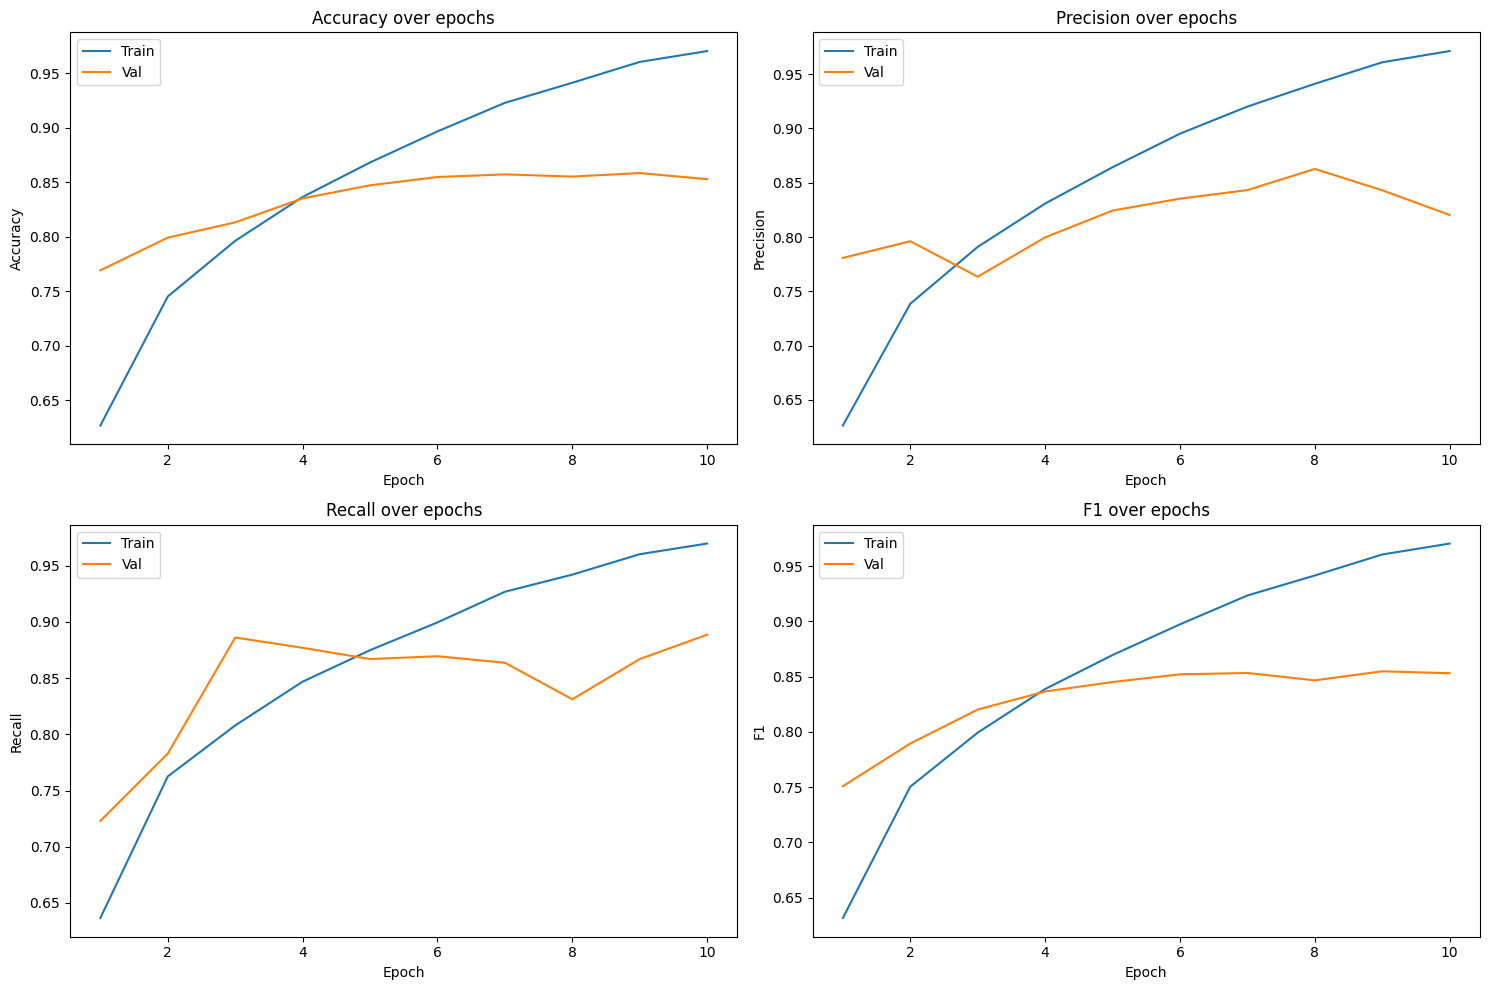


Test Performance:
	Loss: 0.531
	Accuracy: 0.830
	Precision: 0.807
	Recall: 0.866
	F1-score: 0.836


In [8]:
# Model hyperparameters
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = vocab['<pad>']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextCNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
model = model.to(device)

# Training parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()
N_EPOCHS = 10

train_metrics_list = []
val_metrics_list = []

for epoch in range(N_EPOCHS):
    train_loss, train_metrics = train_epoch(model, train_iterator, optimizer, criterion, device)
    val_loss, val_metrics = evaluate(model, val_iterator, criterion, device)
    
    train_metrics_list.append(train_metrics)
    val_metrics_list.append(val_metrics)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_metrics["accuracy"]:.3f}')
    print(f'\tVal. Loss: {val_loss:.3f} |  Val. Acc: {val_metrics["accuracy"]:.3f}')

plot_metrics(train_metrics_list, val_metrics_list)

test_loss, test_metrics = evaluate(model, test_iterator, criterion, device)
print('\nTest Performance:')
print(f'\tLoss: {test_loss:.3f}')
print(f'\tAccuracy: {test_metrics["accuracy"]:.3f}')
print(f'\tPrecision: {test_metrics["precision"]:.3f}')
print(f'\tRecall: {test_metrics["recall"]:.3f}')
print(f'\tF1-score: {test_metrics["f1"]:.3f}')